# Bimorpher Kragbalken - Balkentheorie

Achtung - läuft nicht unter python3.10 (inverse Laplace-Transformation in sympy liefert falsches Ergebnis)
verifiziert auf python 3.7.5

In [2]:
import numpy as np
import sympy

import sympy.solvers

from sympy.integrals.transforms import laplace_transform, inverse_laplace_transform

### Geometriedaten

In [3]:
scale = 1e0  # --> computation in mm
h = 0.002*scale
b = 0.01*scale
l = 0.1*scale

z0 = -h
z1 = 0
z2 = h

zm1 = -h/2
zm2 = h/2

### Materialkonstanten

In [4]:
density = 7750/scale**4

epsilon0 = 8.8541878e-12
CE = 1e9/scale/scale*np.array([[121, 75.9, 75.4, 0, 0, 0],
                          [75.9, 121, 75.4, 0, 0, 0],
                          [75.4, 75.4, 111, 0, 0, 0],
                          [0, 0, 0, 21.1, 0, 0],
                          [0, 0, 0, 0, 21.1, 0],
                          [0, 0, 0, 0, 0, 22.6]])

e15 = 12.3
e31 = -5.4
e33 = 15.8
etensor = 1/scale*np.array([[0, 0, 0, 0, e15, 0],
                     [0, 0, 0, e15, 0, 0],
                     [e31, e31, e33, 0, 0,0]])

epseps = epsilon0*np.array([[916, 0, 0],[0,916,0],[0,0,830]])


SE = np.linalg.inv(CE)
d = np.dot(etensor, SE)
epssigma = epseps + np.dot(d,etensor.transpose())
print(f"S11 = {SE[0,0]}")
print(f"d31 = {d[2,0]}")
print(f"epssigma33 = {epssigma[2,2]}")

EY = 1/SE[0,0]
e = d[2,0]/SE[0,0]
eps = epssigma[2,2] + d[2,0]**2/SE[0,0]

print(f"EY = {EY}")
print(f"e = {e}")
print(f"eps = {eps}")

S11 = 1.637945781724376e-11
d31 = -1.7077929880845888e-10
epssigma33 = 1.510821742286997e-08
EY = 61052081891.69929
e = -10.426431736261014
eps = 1.688883612386289e-08


In [5]:
EA = EY*2*b*h
EI = EY *2*b*h**3/3
rhoA = density*2*b*h

EI_em = b*(e**2*h**3/(12*eps) + e**2*h**3/(12*eps))
EI_eff = EI + EI_em

print(f"rhoA = {rhoA}")
print(f"EA = {EA}")
print(f"EI = {EI}")
print(f"EI_em = {EI_em}")
print(f"EI_eff = {EI_eff}")

rhoA = 0.31
EA = 2442083.2756679715
EI = 3.2561110342239625
EI_em = 0.08582433030800318
EI_eff = 3.341935364531966


In [6]:
V_u = 75
V_o = -75
pz = 0

Nstar = -b*e*(V_u+V_o)
Mstar = -b*e*(V_o*zm1 + V_u*zm2)

print(Mstar)

0.015639647604391523


## Berechnungen mit sympy

x, s und omega werden als symbolische Variablen festgelegt


In [7]:
x = sympy.Symbol('x', positive=True, real=True)
s = sympy.Symbol('s', positive=True, real=True)
omega = sympy.Symbol('omega', positive=True, real=True)

Wir definieren die Matrix A(omega) und den Lastvektor f als symbolische  Matrizen

In [8]:

A = sympy.Matrix([[0,1,0,0],
                  [0,0,0,-1/EI_eff],
                  [-omega**2 *rhoA,0,0,0],
                  [0,0,1,0]])

f = sympy.Matrix([0,-Mstar/EI_eff, -pz, 0])


z0 und zL bezeichnen den Zustandsvektor bei x=0 und x=L. Die unbekannten Größen sind (für den Kragbalken) Querkraft und Biegemoment in der Einspannung (Q0, M0) und Durchbiegung und Biegewinkel am freien Ende (wL, psiL).

Wir definieren Q0, M0, wL, psiL wieder als symbolische Größen.

In [9]:
Q0, M0, wL, psiL = sympy.symbols('Q0 M0 wL psiL', real=True) 
z0 = sympy.Matrix([0,0,Q0,M0])
zL = sympy.Matrix([wL,psiL,0,0])

Wir definieren die Matrix (sI - A), und berechnen ihre Inverse symbolisch (invmatrix)

In [10]:
matrix = s*sympy.eye(4) - A
invmatrix = matrix.inv()

Wir transformieren den Lastvektor mit der Laplacetransformation -> fhat

noconds=True sorgt dafür, dass nur fhat zurückgegeben wird, und nicht die Einschränkungen an s für die die Transformation konvergiert. 

In [11]:
fhat = laplace_transform(f, x, s, noconds=True, simplify=True)

print("fhat = ", fhat)

fhat =  Matrix([[0], [-0.00467981750047456/s], [0], [0]])


fbar = L^-1(invmatrix*fhat)

In [17]:
invmatrix_fhat = invmatrix * fhat
#print(invmatrix_fhat)

In [13]:
fbar = inverse_laplace_transform(invmatrix_fhat, s, x, noconds=True)

U = L^-1(invmatrix)

In [14]:
U = inverse_laplace_transform(invmatrix, s, x, noconds=True)

Schleife über die verschiedenen Kreisfrequenzen omega: für die symbolische Variable omega wird in jedem Schleifendurchlauf der aktuelle numerische Wert om eingesetzt.

Für jedes omega=om wird die Gleichung

     zL = U(l,om)*z0 + fbar
     
aufgestellt (und als Liste von Gleichungen (U(l,om)*z0)[i] + fbar[i] - zL[i] = 0 übergeben)

sympy.linsolve gibt dabei eine Lösungsmenge (FiniteSet) zurück. Mit

     solution, = sympy.linsolve(...)
     
erreicht man, dass die erste berechnete Lösung verwendet wird (wir wissen ja, dass es nur genau eine Lösung gibt). wL ist dann der erste Eintrag von solution, psiL der zweite usw.

In [15]:
omegas = []
ws = []

for om in np.linspace(1e-6,10000,101):

    eqn = U.evalf(subs={x:l, omega:om})*z0 + fbar.evalf(subs={x:l, omega:om}) - zL
    system_of_equations = [eqn[i] for i in range(4)]
    solution, = sympy.linsolve(system_of_equations, (wL, psiL, M0, Q0))
    omegas += [om]
    ws += [solution[0]]

In [123]:
outfile = open("frequenzlauf_1d_.txt","w")
for i in range(len(omegas)):
    print(f"{omegas[i]}\t{np.abs(ws[i])}", file=outfile)
outfile.close()

Plot des Frequenzlaufes und Vergleich mit den entsprechenden Daten aus der 3d-Rechnung bzw. 2d plane strain/plane stress

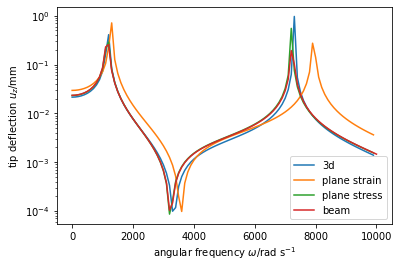

In [3]:
import matplotlib.pyplot as plt
import numpy as np


data3d = np.loadtxt("../chapter2/frequenzlauf_3d.txt")
datapstrain = np.loadtxt("../chapter2/frequenzlauf_planestrain.txt")
datapstress = np.loadtxt("../chapter2/frequenzlauf_planestress.txt")
data1d = np.loadtxt("frequenzlauf_1d.txt")


plt.semilogy(data3d[:,0], data3d[:,1], label="3d")
plt.semilogy(datapstrain[:,0], datapstrain[:,1], label="plane strain")
plt.semilogy(datapstress[:,0], datapstress[:,1], label="plane stress")
plt.semilogy(data1d[:,0], data1d[:,1]*1e3, label="beam")  #???

plt.xlabel(r"angular frequency $\omega$/rad s$^{-1}$")
plt.ylabel(r"tip deflection $u_z$/mm")
plt.legend()


plt.savefig("bimbeam_freq_beam.png")
plt.show()
